In [102]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import pandas as pd 
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime

from split_filename import *
from GOLD import *

import warnings
warnings.filterwarnings("ignore",category = RuntimeWarning)




def magnetic_equator(filename = 'mag_inclination_2021.txt'):
    
    df = pd.read_csv(filename, delim_whitespace = True)

    df = pd.pivot_table(df, columns = 'lon', index = 'lat', values = 'B')
    
    return df.columns.values, df.index.values,  df.values

cols, idx, dat = magnetic_equator()



In [121]:
infile = 'C:\\Users\\Luiz Felipe\\Downloads\\NMAX2019111120191112\\tmp\\archive_L2\\2019\\315\\'
filename = 'GOLD_L2_NMAX_2019_315_v01_r01_c01.nc'

ds = xr.open_dataset(infile + filename)

ds.coords['nscans'] = bytes_string(ds['scan_start_time'])
ds.coords['nmask'] = ds['mask_wavelength']



def sep_channels(ds, channel = 'B'):
    
    if channel ==  'A':
        ch = ds.isel(nscans = np.arange(12, 24))
    else:
        ch = ds.isel(nscans = np.arange(12))

    combine = []
    times = []
    
    n = ch.isel(nscans = np.arange(0, len(ch.nscans), 2))
    s = ch.isel(nscans = np.arange(1, len(ch.nscans), 2))

    for i in range(len(n.nscans)):
        ds1 = xr.concat([s.isel(nscans = i), n.isel(nscans = i)], dim = 'nlats')
        combine.append(ds1)
        times.append(pd.to_datetime(n.isel(nscans = i)['nscans'].values))
    return combine, times

da, ta = sep_channels(ds, channel = 'A')

db, tb = sep_channels(ds, channel = 'B')




C:\Users\Luiz Felipe\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


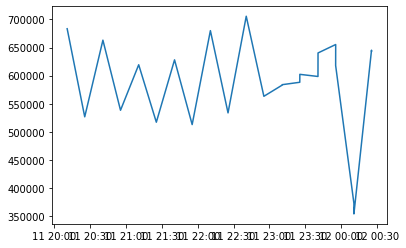

In [128]:
nmax = ds.mean(dim = ['nlats', 'nlons'])['nmax'].values
nmax
time = np.array(ds.nscans.values, dtype = 'datetime64')
plt.plot(time, nmax)

In [119]:
times = tb + ta
ds = db + da

times = times[::2]
combine = ds[::2]


nmax_mean = [np.array(ds[i]['nmax'].mean().values) for i in range(len(ds))]

np.concatenate(np.array(nmax_mean))

nmax_mean

ValueError: zero-dimensional arrays cannot be concatenated

C:\Users\Luiz Felipe\anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


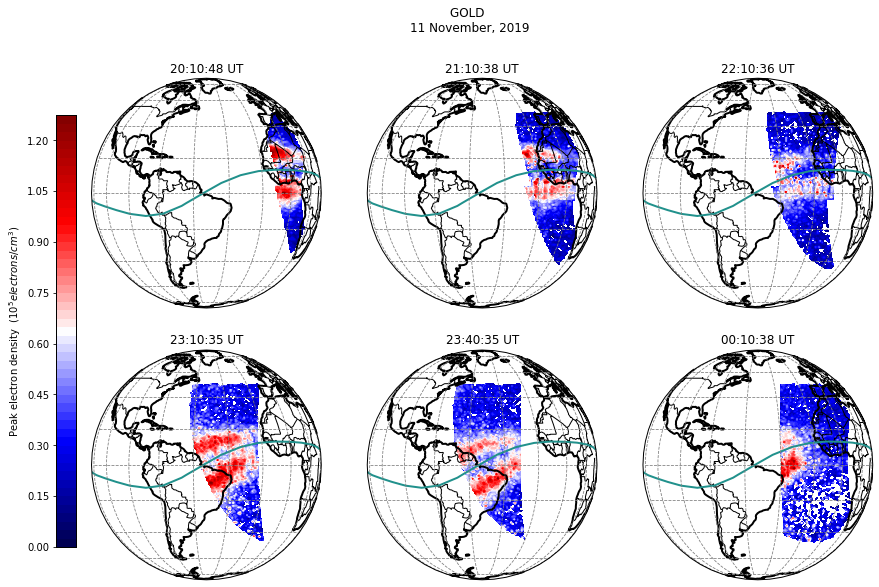

In [105]:
fig, axes = plt.subplots(figsize = (14, 10), ncols = 3, nrows = 2,
                       subplot_kw={'projection': 
                                   ccrs.Orthographic(central_longitude 
                                                     = -47.5)})
plt.subplots_adjust(wspace = 0.2, hspace = 0)


args = ds[0]['nmax'].attrs

name = f"{args['CATDESC']}  ($10^5 {args['UNITS']}$)"

for ax, dataset, timef in zip(axes.flat, combine, times):
    features_of_map(ax)
    
    lons = dataset['longitude'].values
    lats = dataset['latitude'].values
    data = dataset['nmax'].values / 10e5
    
    data[lats > 45] = np.nan
    
    ax.contour(cols, idx, dat, 1, linewidths = 2, color = 'k',
                   transform = ccrs.PlateCarree())


    img = ax.contourf(lons, lats, data, 50, cmap = 'seismic', 
                transform = ccrs.PlateCarree())
    
    ax.set(title = str(timef.time()) + ' UT')
    
    cbar_ax = fig.add_axes([.09, 0.2, 0.02, 0.6])

    cs = fig.colorbar(img, cax=cbar_ax, ticklocation='left')

    cs.set_label(name)

title_date = split_filename(filename).date()
        
fig.suptitle('GOLD \n' + title_date, y = .95)

plt.show()

In [109]:
def figure_name(files, emission):
    
    emission = emission.replace(' ', '_')
    
    if isinstance(files, list):
    
        start = split_filename(files[0][0])
        end = split_filename(files[-1][0])
        time_start, time_end = start.time().replace(':',''), end.time().replace(':','')
        return f"GOLD_{start.product}_{emission}_{date}_{time_start}_{time_end}"
    else:
        start = split_filename(filename)
        if start.level == 'L2':
             return f"GOLD_{emission.upper()}_{start.level}_{str(start.date(extent = False)).replace('-', '_')}"
        

FigureName = figure_name(filename, 'nmax')

FigureName
times

[Timestamp('2019-11-11 20:10:48'),
 Timestamp('2019-11-11 21:10:38'),
 Timestamp('2019-11-11 22:10:36'),
 Timestamp('2019-11-11 23:10:35'),
 Timestamp('2019-11-11 23:40:35'),
 Timestamp('2019-11-12 00:10:38')]

In [108]:
PathOut = 'C:\\Users\\Luiz Felipe\\Google Drive\\Doutorado\\Modelos_Latex_INPE\\Figuras1\\'
fig.savefig(PathOut + FigureName + '.png', dpi = 100, quality = 95, bbox_inches="tight")


In [19]:
class NMAX:
    
    def __init__(self, ds, parameter = 'nmax'):
        self.ds = ds
        self.parameter = parameter
        self.hour_list = []
        
        for hemisphere in range(2):
            sel = self.ds.isel(nscans = np.arange(hemisphere, len(self.ds.nscans), 2))

            scans_values = sel['nscans'].values

            time_list = [[scans_values[i], scans_values[i + 1]] for i 
                         in range(len(scans_values) - 1)]

            for item in time_list[::2]:
                
                start = str(item[0].time())[:-3]
                end = str(item[1].time())[:-3]
                self.hour_list.append(f"{start}-{end}")
            
        
    def hours(self, step = 1):
        return self.hour_list
            
NMAX(ds)